In [1]:
import os
import sys

%matplotlib inline
import time
import pylab as pl
from IPython import display

import numpy as np
import argparse
import h5py
import math
import time
import logging
import matplotlib.pyplot as plt
import torchvision
from sklearn import metrics
import _pickle as cPickle
import shutil

from tqdm import tqdm_notebook as tqdm
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from models import CNN_two, Cnn6
from data_generator import medleyDataset, medleyDataset_logmel, medleyDataset_audio, get_mean_var

from losses import get_loss_func
from metrics import macro_f1

In [2]:
def save_checkpoint(state, is_best, directory, filename='checkpoint.pth.tar'):
    if not directory == None:
        if not os.path.exists(directory):
            os.makedirs(directory)

        filename = os.path.join(directory, filename)
        torch.save(state, filename)
        if is_best:
            shutil.copyfile(filename, os.path.join(directory,'model_best.pth.tar'))

In [3]:
# scatter_type = '6_8_33075'
scatter_type = '9_8_132300'
# scatter_type = 'logmel'

train_dir = '/home/laura/MedleyDB/processed/'+scatter_type+'/train'
val_dir = '/home/laura/MedleyDB/processed/'+scatter_type+'/val'

classes_num = 18
if scatter_type == 'logmel':
    mean_logmel, var_logmel = get_mean_var(train_dir)
    time_steps = 827
    freq_bins = 64
    
    train_dataset = medleyDataset_logmel(
        train_dir, 
        time_steps, 
        freq_bins, 
        classes_num, 
        mean_logmel, 
        var_logmel
    )
    val_dataset = medleyDataset_logmel(
        val_dir, 
        time_steps, 
        freq_bins, 
        classes_num, 
        mean_logmel, 
        var_logmel
    )
    
else:
    if scatter_type == '9_8_132300':
        input_length = 259
        order1_length = 62
        order2_length = 237
    elif scatter_type == '6_8_33075':
        input_length = 517
        order1_length = 38
        order2_length = 87
    
    mean_order1, var_order1, mean_order2, var_order2 = get_mean_var(train_dir)
    train_dataset = medleyDataset(
        train_dir,
        input_length,
        order1_length,
        order2_length,
        classes_num,
        mean_order1,
        var_order1,
        mean_order2,
        var_order2
    )
    val_dataset = medleyDataset(
        val_dir,
        input_length,
        order1_length,
        order2_length,
        classes_num,
        mean_order1,
        var_order1,
        mean_order2,
        var_order2
    )
    
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=os.cpu_count(),
    shuffle=True,
    drop_last=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=1,
    num_workers=os.cpu_count(),
    shuffle=True
)

print(len(train_dataset))
print(len(val_dataset))

2999
439


In [4]:
if scatter_type == 'logmel':
    model = Cnn6(classes_num=classes_num, time_steps=time_steps, freq_bins=freq_bins)
else:
    model = CNN_two(classes_num=classes_num)

model.cuda()

loss_func = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

In [5]:
sum(p.numel() for p in model.parameters())

74823698

In [6]:
losses_train = []
losses_val = []
f1_val = []
epoch = 0
threshold = 0.2
best_f1 = 0
directory_save = None

early_stop = False

while not early_stop:
    running_loss = 0.0
    is_best = False
    
    for batch_data_dict in tqdm(train_loader):
        if scatter_type == 'logmel':
            batch_input = batch_data_dict['logmel'].cuda()
            batch_target = batch_data_dict['target'].cuda()
            batch_output_dict = model(batch_input)
        else:
            batch_input1 = batch_data_dict['order1'].cuda()
            batch_input2 = batch_data_dict['order2'].cuda()
            batch_target = batch_data_dict['target'].cuda()
            batch_output_dict = model(batch_input1, batch_input2)
        
        batch_target_dict = {'target': batch_target}
        
        loss = loss_func(batch_output_dict['clipwise_output'], batch_target_dict['target'])

        # Backward
        loss.backward()
        running_loss += loss.item() * train_loader.batch_size
        
        optimizer.step()
        optimizer.zero_grad()
    
    epoch_loss = running_loss / len(train_dataset)
    losses_train.append(epoch_loss)

    display.clear_output(wait=True)
    print('Epoch', epoch, ',  Train loss:', epoch_loss, end='\r')
    model.eval()

    val_loss = 0.0
    batches_target = []
    batches_pred = []
    
    for batch_data_dict in val_loader:
        if scatter_type == 'logmel':
            batch_input = batch_data_dict['logmel'].cuda()
            batch_target = batch_data_dict['target'].cuda()
            batch_output_dict = model(batch_input)
        else:
            batch_input1 = batch_data_dict['order1'].cuda()
            batch_input2 = batch_data_dict['order2'].cuda()
            batch_target = batch_data_dict['target'].cuda()
            batch_output_dict = model(batch_input1, batch_input2)
        
        batch_target_dict = {'target': batch_target}

        loss = loss_func(batch_output_dict['clipwise_output'], batch_target_dict['target'])

        val_loss += loss.item() * val_loader.batch_size

        batches_target.append(batch_target_dict['target'].detach().cpu().numpy()[0])
        batches_pred.append((batch_output_dict['clipwise_output'].detach().cpu().numpy()[0]>threshold) * 1.0)

    val_loss = val_loss / len(val_dataset)

    losses_val.append(val_loss)

    if epoch > 100 and losses_val[-1] > min(losses_val):
        early_stop = True

    f1_score = macro_f1(batches_target, batches_pred)
    f1_val.append(f1_score)
    
    if losses_val[-1] == min(losses_val):
        is_best = True
        
    save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'f1_score': f1_score,
        'optimizer' : optimizer.state_dict(),
    }, is_best, directory_save)
    
    model.train()

    # pl.plot(losses_train)
    # pl.plot(losses_val)
    # display.clear_output(wait=True)
    # display.display(pl.gcf())
    # time.sleep(0.1)

    epoch += 1

Macro F1 0.4446826078940835000504105213944772


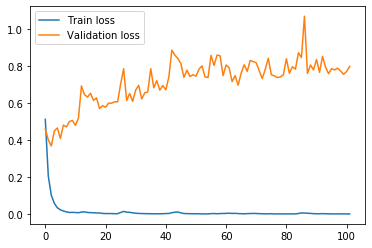

In [7]:
plt.plot(losses_train, label='Train loss')
plt.plot(losses_val, label='Validation loss')
plt.legend()
plt.show()

In [8]:
print(min(losses_val))

0.3680214680018485


In [14]:
print(max(f1_val))
print(len(f1_val))
print(np.argmax(np.array(f1_val)))
print(losses_val[20])

0.45527231868313084
102
20
0.578001221319966


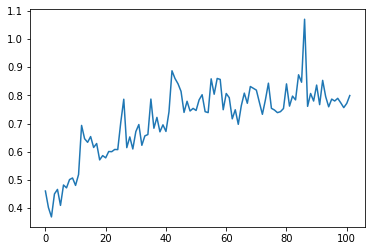

In [10]:
plt.plot(losses_val)

In [15]:
print(min(losses_val))
print(np.argmin(np.array(losses_val)))
print(f1_val[2])

0.3680214680018485
2
0.4478474318471416


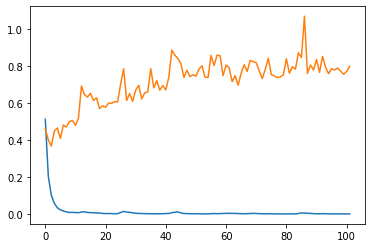

In [12]:
plt.plot(losses_train)
plt.plot(losses_val)
plt.show()

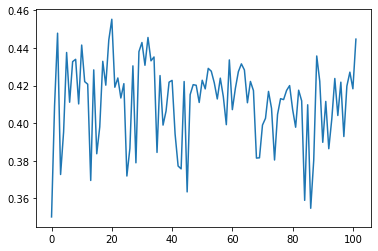

In [13]:
plt.plot(f1_val)